# MCMC diagnostics with [Arviz](https://python.arviz.org/)

This tutorial shows how to evaluate the quality of MCMC samples generated via `sbi` using the `arviz` package.

Outline:

1. Train MNLE to approximate the likelihood underlying the simulator
2. Run MCMC using `pyro` MCMC samplers via `sbi` interface
3. Use `arviz` to visualize the posterior, predictive distributions and MCMC diagnostics.


In [1]:
import arviz as az
import torch
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Gamma

from sbi.inference import MNLE, MCMCPosterior, likelihood_estimator_based_potential
from sbi.utils import MultipleIndependent

# Seeding
torch.manual_seed(1);

In [2]:
# Toy simulator for mixed data
def mixed_simulator(theta):
    beta, ps = theta[:, :1], theta[:, 1:]

    choices = Binomial(probs=ps).sample()
    rts = InverseGamma(concentration=2 * torch.ones_like(beta), rate=beta).sample()

    return torch.cat((rts, choices), dim=1)


# Define independent priors for each dimension.
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
    ],
    validate_args=False,
)

## Train MNLE to approximate the likelihood

For this tutorial, we will use a simple simulator with two parameters. For details see
the [example on the decision making model](https://sbi.readthedocs.io/en/latest/tutorials/Example_01_DecisionMakingModel.html).

Here, we pass `mcmc_method="nuts"` in order to use the underlying [`pyro` No-U-turn sampler](https://docs.pyro.ai/en/1.8.1/mcmc.html#nuts), but it would work as well with other samplers (e.g. "slice_np_vectorized", "hmc").

Additionally, when calling `posterior.sample(...)` we pass `return_arviz=True` so that the [`Arviz InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) object is returned. This object gives us access to the wealth of MCMC diagnostics tool provided by `arviz`.


In [ ]:
# Generate training data and train MNLE.
num_simulations = 10000
theta = prior.sample((num_simulations,))
x = mixed_simulator(theta)

trainer = MNLE(prior)
likelihood_estimator = trainer.append_simulations(theta, x).train()

## Run Pyro NUTS MCMC and obtain `arviz InferenceData` object


In [ ]:
# Simulate "observed" data x_o
torch.manual_seed(42)
num_trials = 100
theta_o = prior.sample((1,))
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))

# Set MCMC parameters and run Pyro NUTS.
mcmc_parameters = dict(
    num_chains=4,
    thin=5,
    warmup_steps=50,
    init_strategy="proposal",
    method="nuts_pyro",
)
num_samples = 1000

# get the potential function and parameter transform for constructing the posterior
potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x_o
)
mnle_posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform, **mcmc_parameters
)

mnle_samples = mnle_posterior.sample(
    (num_samples,), x=x_o, show_progress_bars=False
)
# get arviz InferenceData object from posterior
inference_data = mnle_posterior.get_arviz_inference_data()


## Generate `arviz` plots

The resulting `InferenceData` object can be passed to most `arviz` plotting functions, and there are plenty see [here](https://arviz-devs.github.io/arviz/examples/index.html#) for an overview.

To get a better understanding of the `InferenceData` object see [here](https://arviz-devs.github.io/arviz/schema/schema.html).

Below and overview of common MCMC diagnostics plot, see the corresponding `arviz` documentation for interpretation of the plots.

We will a full use-case using the SBI-MCMC-arviz workflow soon.


In [5]:
print(inference_data.posterior)

<xarray.Dataset> Size: 50kB
Dimensions:      (chain: 4, draw: 1250, theta_dim_0: 2)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 10kB 0 1 2 3 4 5 ... 1244 1245 1246 1247 1248 1249
  * theta_dim_0  (theta_dim_0) int64 16B 0 1
Data variables:
    theta        (chain, draw, theta_dim_0) float32 40kB 1.908 0.7609 ... 0.9063
Attributes:
    created_at:     2024-08-23T15:56:16.510051+00:00
    arviz_version:  0.19.0


### Diagnostic plots


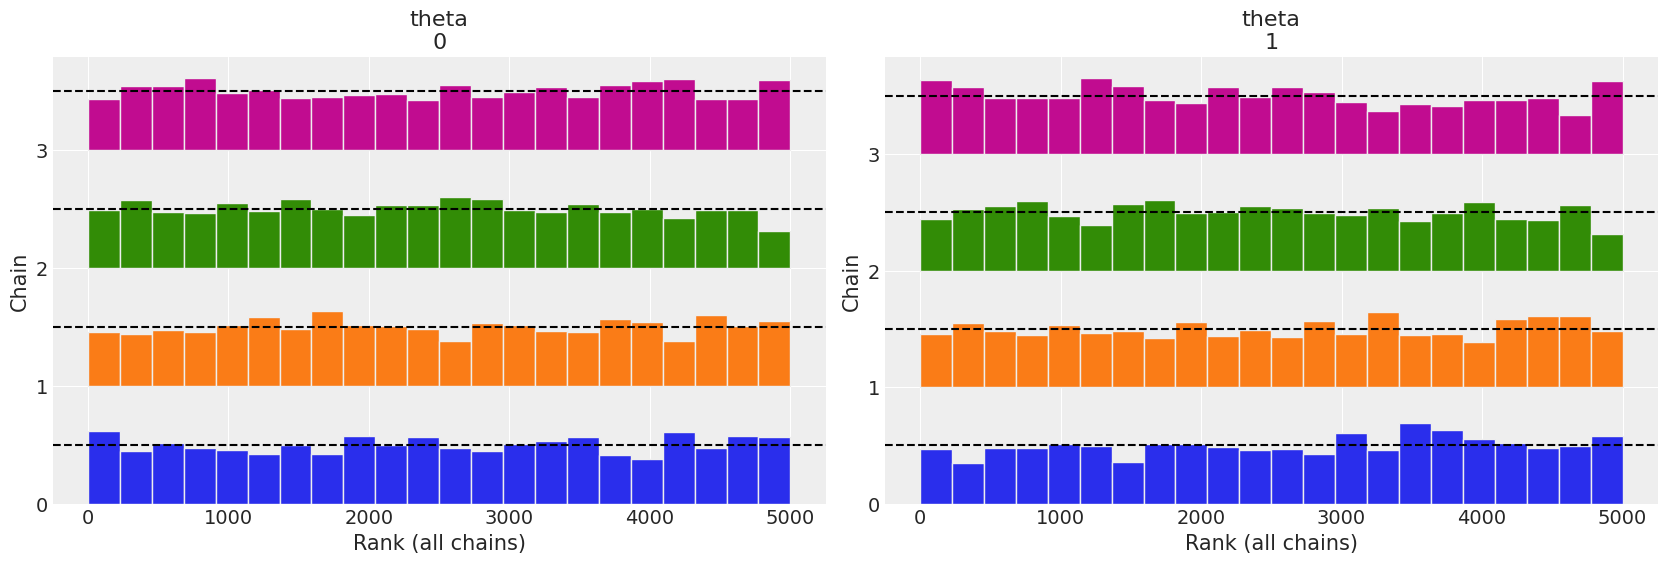

In [6]:
az.style.use("arviz-darkgrid")
az.plot_rank(inference_data)

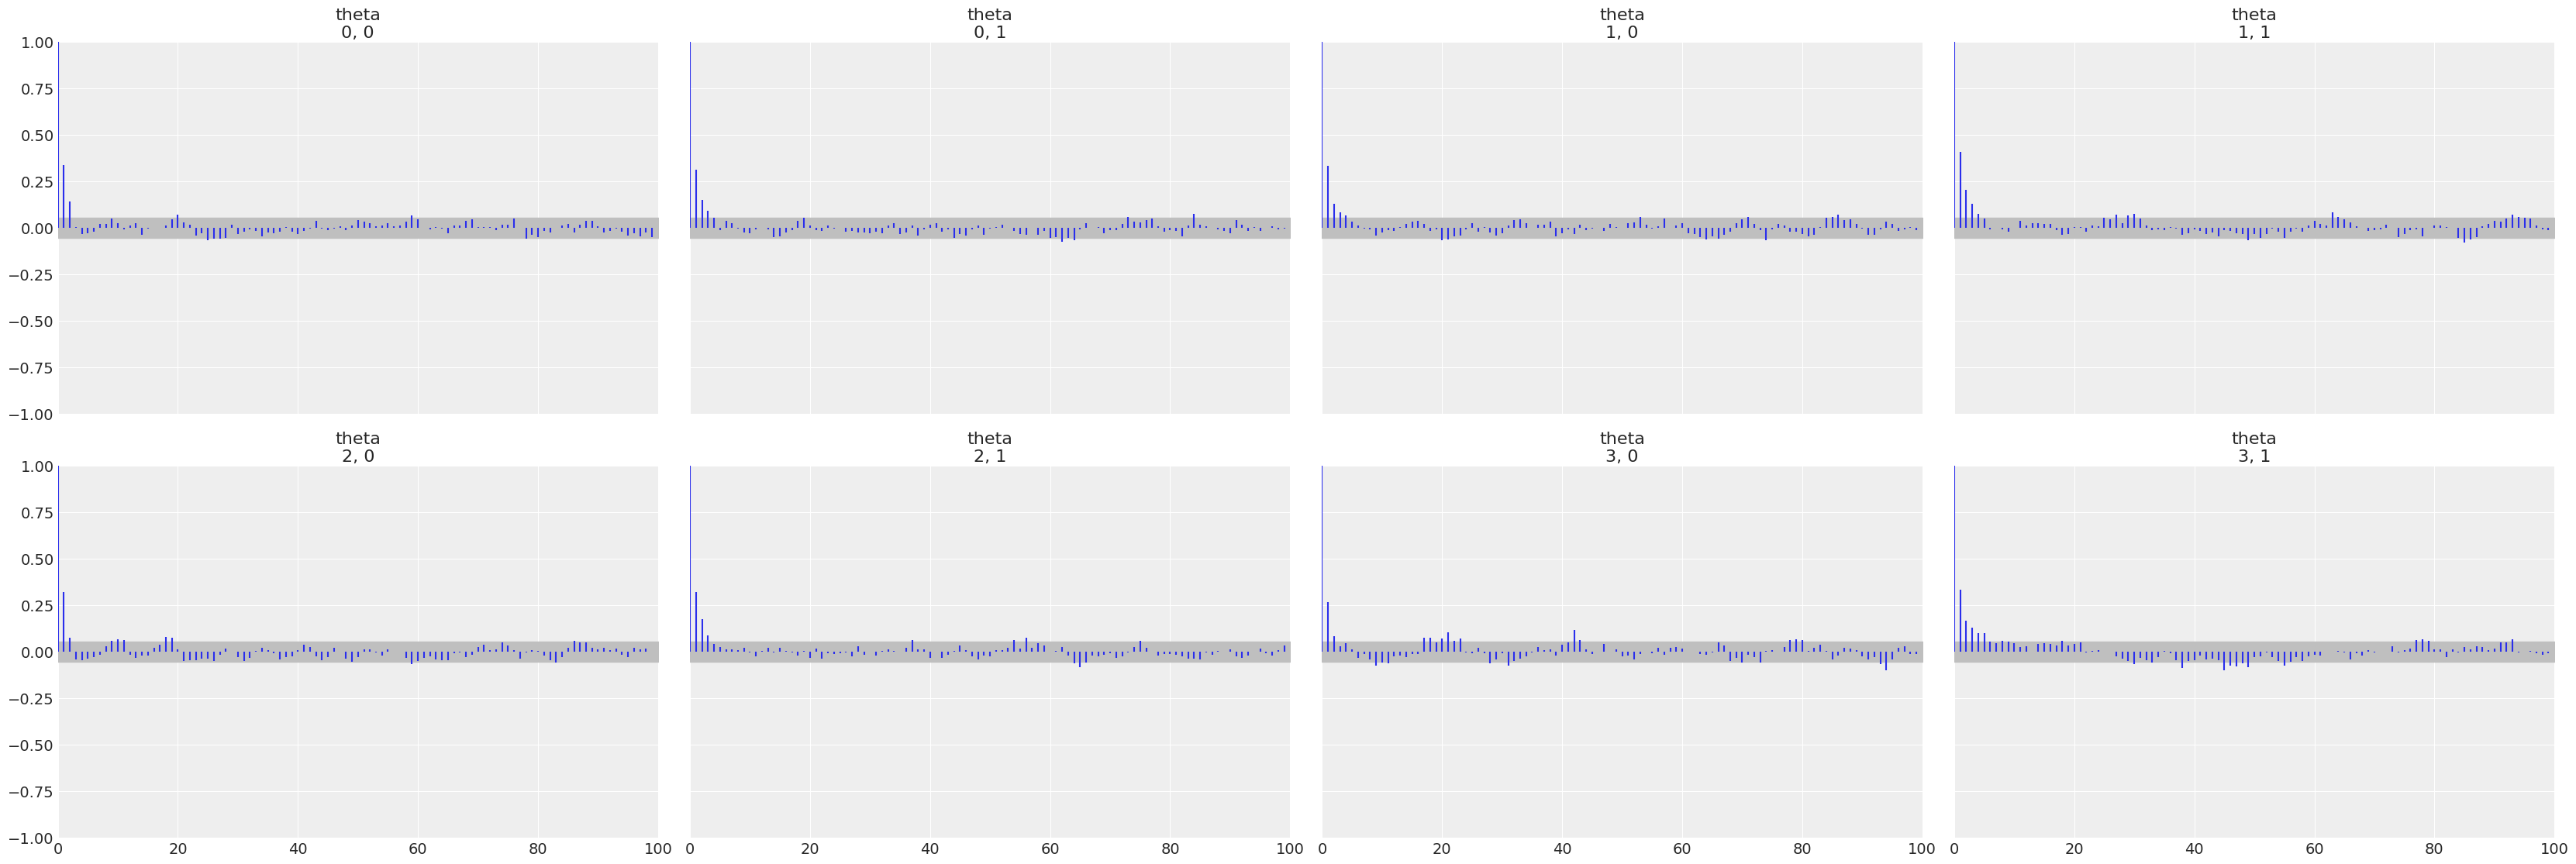

In [7]:
az.plot_autocorr(inference_data);

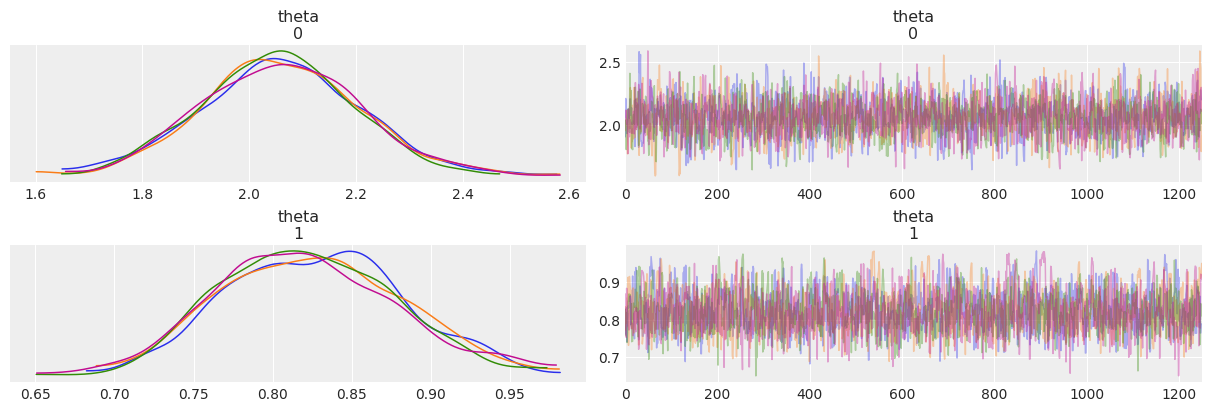

In [8]:
az.plot_trace(inference_data, compact=False);

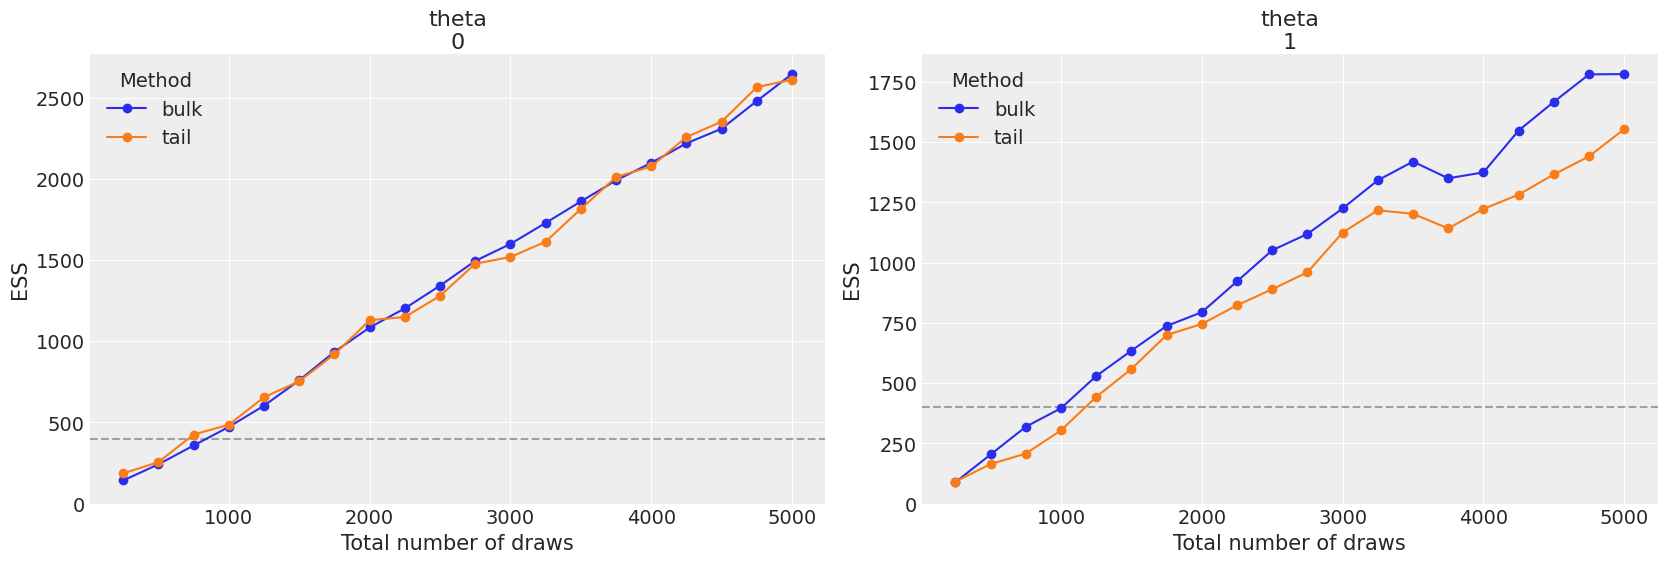

In [9]:
az.plot_ess(inference_data, kind="evolution");

### Posterior density plots


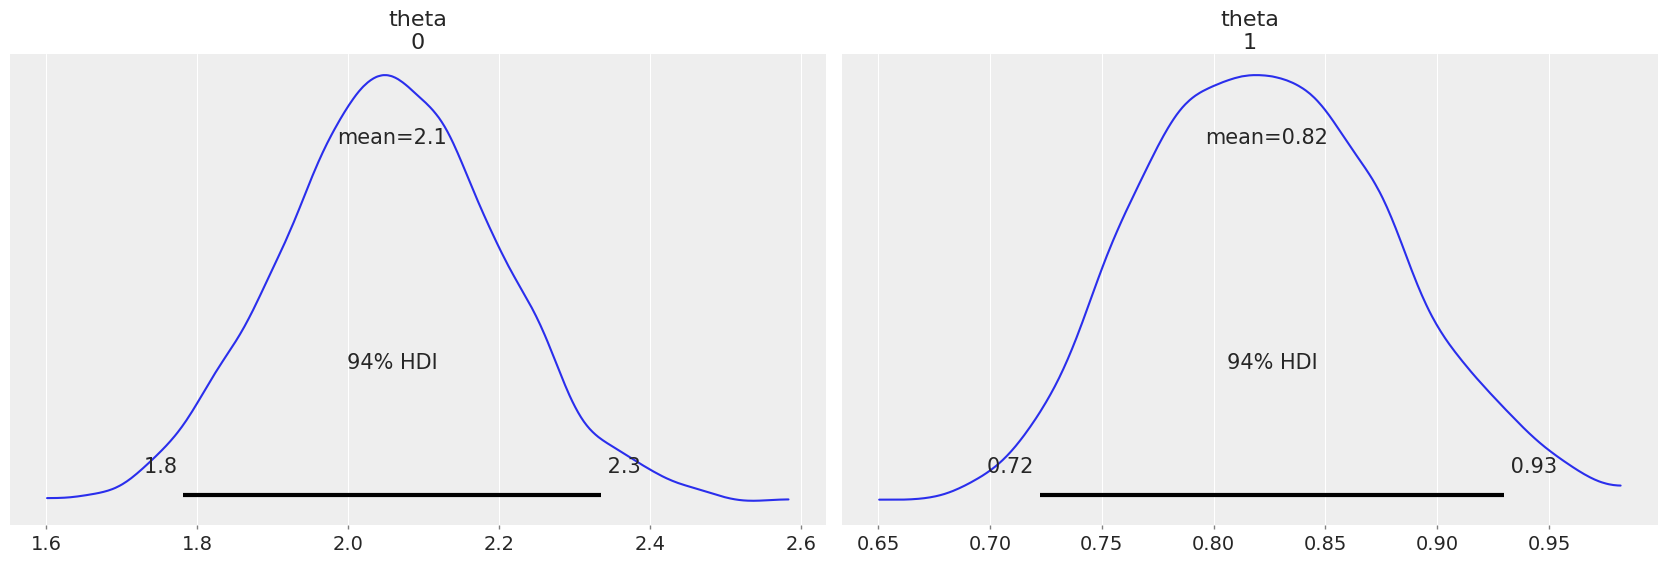

In [10]:
az.plot_posterior(inference_data)

In [11]:
print(
    f"""Given the {num_trials} we observed, the posterior is centered around
    true underlying parameters theta_o: {theta_o}"""
)

Given the 100 we observed, the posterior is centered around
    true underlying parameters theta_o: tensor([[1.9622, 0.7550]])


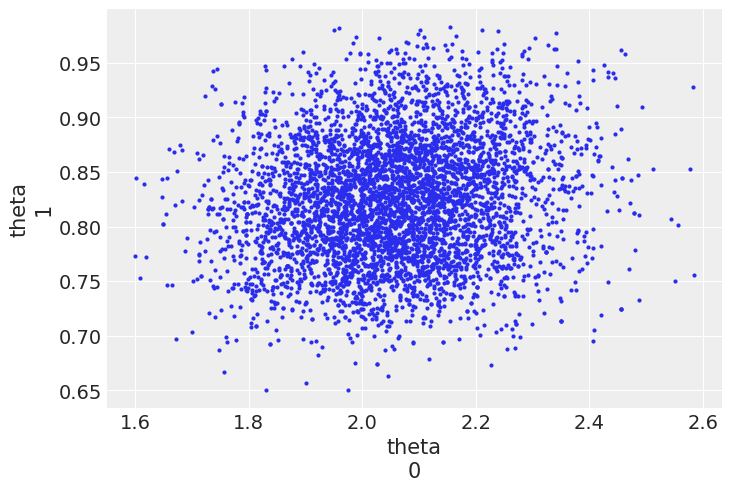

In [12]:
az.plot_pair(inference_data)

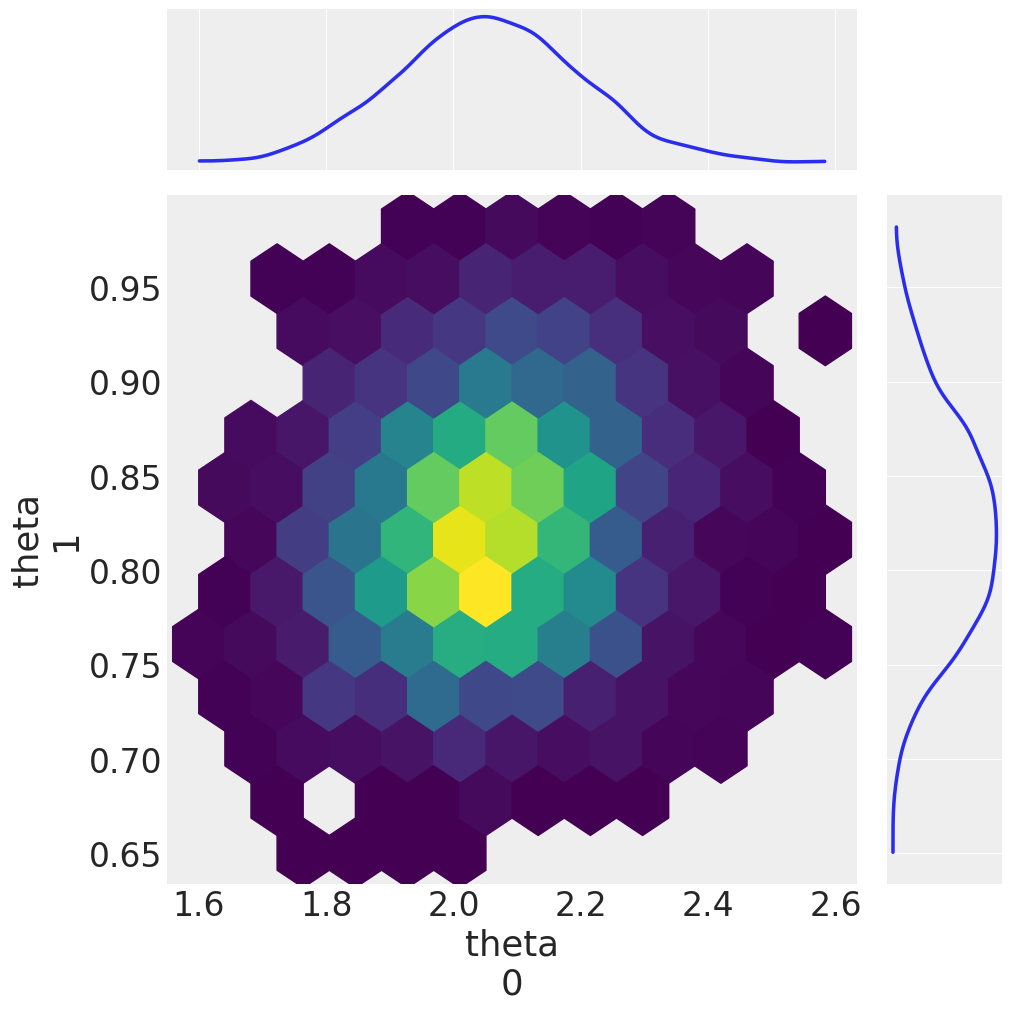

In [13]:
az.plot_pair(
    inference_data,
    var_names=["theta"],
    kind="hexbin",
    marginals=True,
    figsize=(10, 10),
)